In [1]:
#requirements

import os
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transform
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
import torchvision
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
import random

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data_dir = '/content/drive/MyDrive/Kaggle/Covid19-dataset'

In [4]:
os.listdir(data_dir)

['train', 'test']

In [5]:
data_dir

'/content/drive/MyDrive/Kaggle/Covid19-dataset'

In [6]:
train_dir = data_dir + "/train"
test_dir = data_dir + "/test"

In [7]:
os.listdir(train_dir)

['Viral Pneumonia', 'Covid', 'Normal']

In [8]:
os.listdir(test_dir)

['Covid', 'Viral Pneumonia', 'Normal']

In [9]:
dataset = ImageFolder(data_dir)
dataset

Dataset ImageFolder
    Number of datapoints: 317
    Root location: /content/drive/MyDrive/Kaggle/Covid19-dataset

In [10]:
train_folder = ImageFolder(train_dir)
test_folder = ImageFolder(test_dir)

In [11]:
train_folder

Dataset ImageFolder
    Number of datapoints: 251
    Root location: /content/drive/MyDrive/Kaggle/Covid19-dataset/train

In [12]:
test_folder

Dataset ImageFolder
    Number of datapoints: 66
    Root location: /content/drive/MyDrive/Kaggle/Covid19-dataset/test

In [13]:
classes = train_folder.classes
classes

['Covid', 'Normal', 'Viral Pneumonia']

- There are 70 files of Normal in train set.
- There are 111 files of Covid in train set.
- There are 70 files of Viral Pneumonia in train set.

## Visualize images

In [14]:
%matplotlib inline

`<PIL.Image.Image>`, is a PIL image object, and `1` is the label of the image. In this case, `Normal` is the class label for the 112th image.

(1600, 1264)


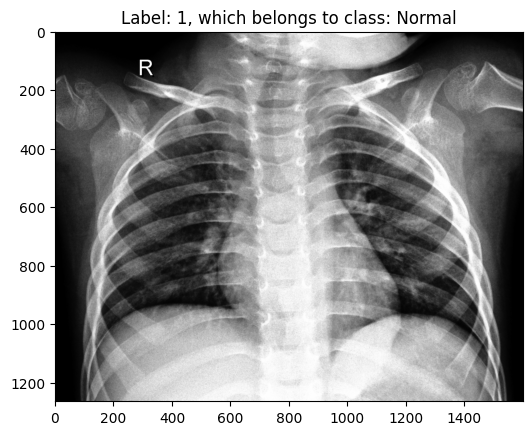

In [15]:
img, label = train_folder[112]

plt.imshow(img)
plt.title(f"Label: {label}, which belongs to class: {classes[label]}")
print(img.size)

(1336, 1024)


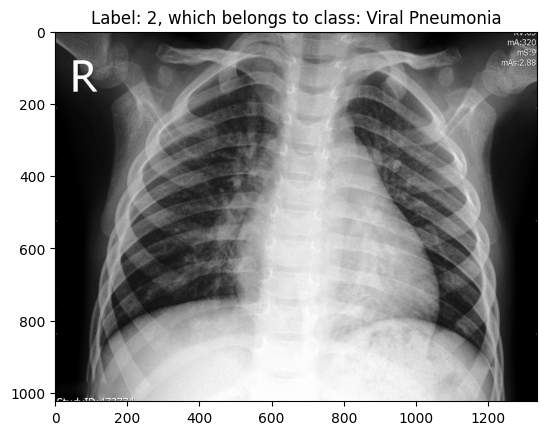

In [16]:
img, label = train_folder[200]

plt.imshow(img)
plt.title(f"Label: {label}, which belongs to class: {classes[label]}")
print(img.size)

(1695, 1570)


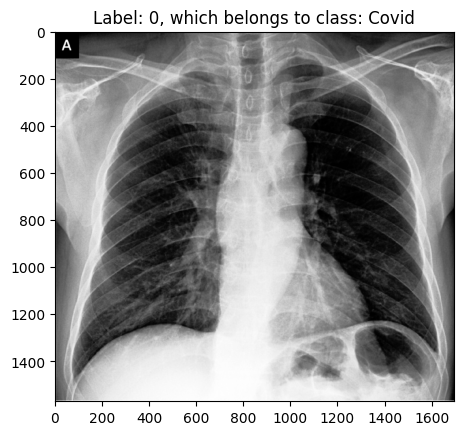

In [17]:
img, label = train_folder[29]
plt.imshow(img)
plt.title(f"Label: {label}, which belongs to class: {classes[label]}")
print(img.size)

## Transformation and Augmentation

In [18]:
train_set = ImageFolder(train_dir, transform.Compose([
    transform.Resize((250, 250)),            # Resize image to 256x256
    transform.RandomHorizontalFlip(p=0.5),   # Randomly flip the image horizontally
    transform.ToTensor(),                    # Convert the image to a PyTorch tensor
    transform.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
]))


test_set = ImageFolder(test_dir, transform.Compose([
    transform.Resize((250, 250)),
    transform.RandomHorizontalFlip(p=0.5),
    transform.ToTensor(),
    transform.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
]))

In [19]:
train_set

Dataset ImageFolder
    Number of datapoints: 251
    Root location: /content/drive/MyDrive/Kaggle/Covid19-dataset/train
    StandardTransform
Transform: Compose(
               Resize(size=(250, 250), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

## Visualize transformed images

<built-in method size of Tensor object at 0x7e2773f6fc40>


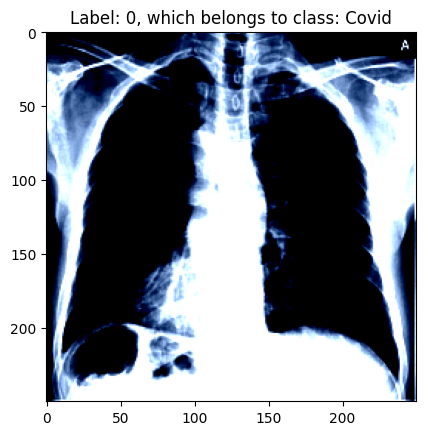

In [20]:
img, label = train_set[29]
plt.imshow(img.permute(1, 2, 0))
plt.title(f"Label: {label}, which belongs to class: {classes[label]}")
print(img.size)

<built-in method size of Tensor object at 0x7e2773f6fe20>


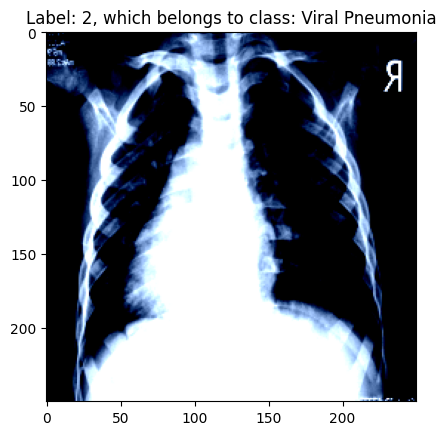

In [21]:
img, label = train_set[200]
plt.imshow(img.permute(1, 2, 0))
plt.title(f"Label: {label}, which belongs to class: {classes[label]}")
print(img.size)

<built-in method size of Tensor object at 0x7e2773e98400>


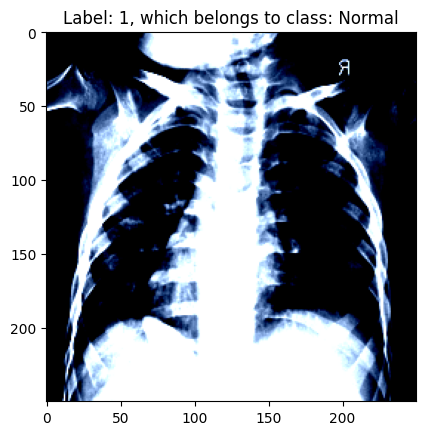

In [22]:
img, label = train_set[112]
plt.imshow(img.permute(1, 2, 0))
plt.title(f"Label: {label}, which belongs to class: {classes[label]}")
print(img.size)

In [23]:
len(train_set)

251

In [24]:
val_pct = 0.25
val_size = int(val_pct * len(train_set))
train_size = int(len(train_set) - val_size)
val_size, train_size

(62, 189)

In [25]:
train_ds, val_ds = random_split(train_set, [train_size, val_size])
len(train_ds), len(val_ds)

(189, 62)

In [26]:
train_dl = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size=8, shuffle=False, num_workers=2, pin_memory=True)

## Visualize a batch of data

In [27]:
def visualize_batch(images, labels):
  grid_img = torchvision.utils.make_grid(images, nrow=8, padding=2)

  np_img = grid_img.numpy().transpose((1, 2, 0))

  plt.figure(figsize=(15, 15))
  plt.imshow(np_img)
  plt.title("Batch of images with labels")
  plt.axis("off")
  plt.show()

  for i in range(len(images)):
    img = images[i]
    label = labels[i].item()

    img = img.permute(1, 2, 0).numpy()

    plt.figure()
    plt.imshow(img)
    plt.title(f"Label: {label}, which is {classes[label]}")
    plt.axis("off")
    plt.show()

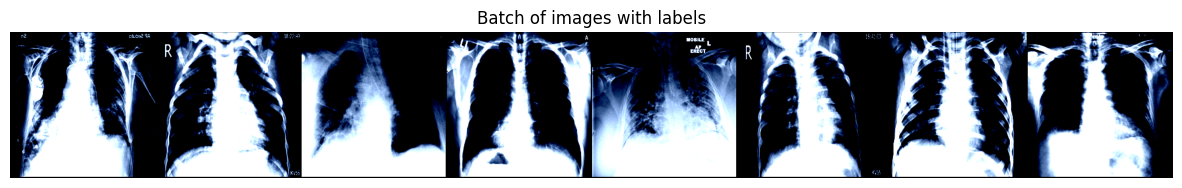

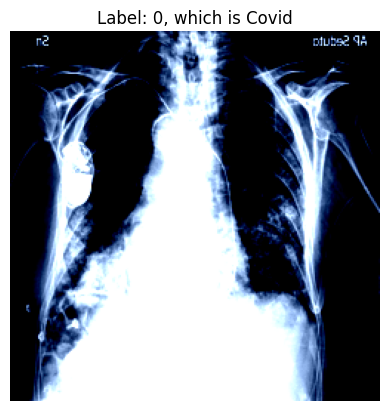

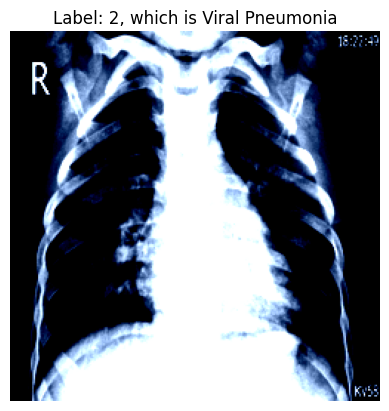

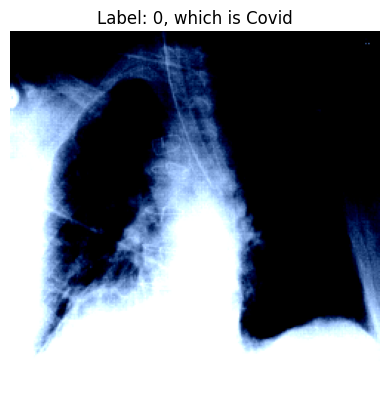

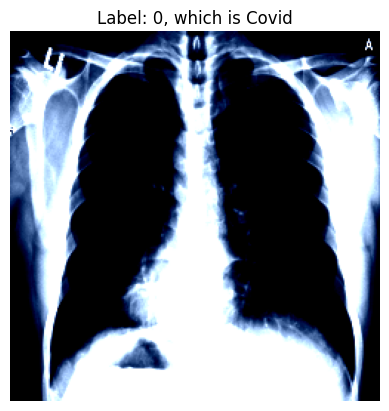

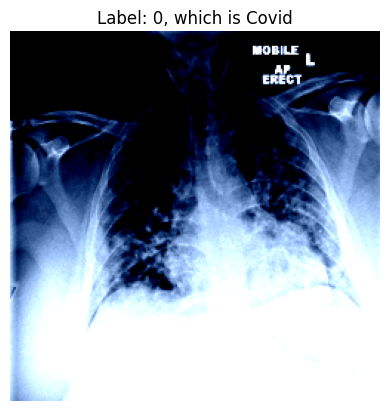

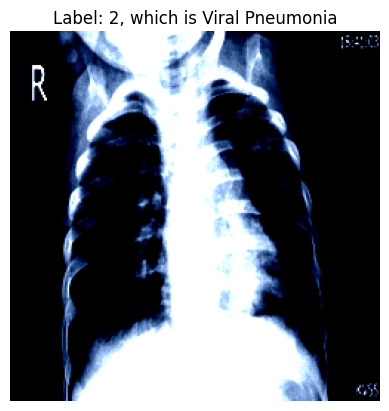

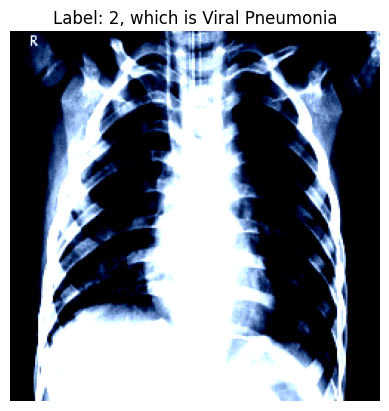

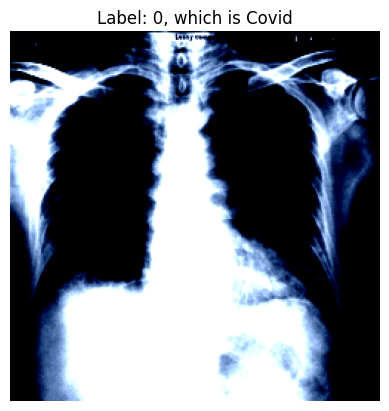

In [28]:
for batch in train_dl:
  images, labels = batch
  visualize_batch(images, labels)
  break

## Define the model

In [29]:
class Covid19Model0(nn.Module):
  def __init__(self):
    super(Covid19Model0, self).__init__()

    # Convolutional layers
    self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
    self.dropout1 = nn.Dropout(0.5)  # Dropout after conv1
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
    self.dropout2 = nn.Dropout(0.5)  # Dropout after conv2
    self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
    self.dropout3 = nn.Dropout(0.5)  # Dropout after conv3

    # Pooling layer
    self.pool = nn.MaxPool2d(2, 2)

    # Fully connected layers
    self.linear1 = nn.Linear(128 * 31 * 31, 256)
    self.dropout4 = nn.Dropout(0.5)  # Dropout after linear1
    self.linear2 = nn.Linear(256, 128)
    self.dropout5 = nn.Dropout(0.5)  # Dropout after linear2
    self.linear3 = nn.Linear(128, 64)
    self.dropout6 = nn.Dropout(0.5)  # Dropout after linear3
    self.linear4 = nn.Linear(64, 3)   # Output layer for 3 classes

  def forward(self, x):
    # Forward pass through the network
    x = F.relu(self.conv1(x))
    x = self.dropout1(x)
    x = self.pool(x)

    x = F.relu(self.conv2(x))
    x = self.dropout2(x)
    x = self.pool(x)

    x = F.relu(self.conv3(x))
    x = self.dropout3(x)
    x = self.pool(x)

    # Flatten the tensor for the fully connected layers
    x = x.view(-1, 128 * 31 * 31)

    x = F.relu(self.linear1(x))
    x = self.dropout4(x)

    x = F.relu(self.linear2(x))
    x = self.dropout5(x)

    x = F.relu(self.linear3(x))
    x = self.dropout6(x)

    x = self.linear4(x)  # Output layer
    return x

In [30]:
model0 = Covid19Model0()
model0

Covid19Model0(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout1): Dropout(p=0.5, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout2): Dropout(p=0.5, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout3): Dropout(p=0.5, inplace=False)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=123008, out_features=256, bias=True)
  (dropout4): Dropout(p=0.5, inplace=False)
  (linear2): Linear(in_features=256, out_features=128, bias=True)
  (dropout5): Dropout(p=0.5, inplace=False)
  (linear3): Linear(in_features=128, out_features=64, bias=True)
  (dropout6): Dropout(p=0.5, inplace=False)
  (linear4): Linear(in_features=64, out_features=3, bias=True)
)

In [31]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model0.parameters(), lr=0.0001)

## Training loop

### finding accuracy of first batch of images, step by step implementation

In [32]:
for images, labels in train_dl:
  outputs = model0(images)
  loss = criterion(outputs, labels)
  break

In [33]:
labels

tensor([0, 2, 2, 0, 2, 2, 1, 1])

In [34]:
labels.size()

torch.Size([8])

In [35]:
labels.size(0)

8

In [36]:
outputs

tensor([[-0.0376,  0.0321, -0.1334],
        [-0.0388, -0.0314, -0.0500],
        [ 0.0356,  0.1268,  0.0434],
        [ 0.0123,  0.0346, -0.1072],
        [-0.1342,  0.0075, -0.2475],
        [-0.0220,  0.0072, -0.0558],
        [ 0.0657, -0.0623, -0.2312],
        [ 0.1860,  0.3455,  0.1069]], grad_fn=<AddmmBackward0>)

In [37]:
outputs.data

tensor([[-0.0376,  0.0321, -0.1334],
        [-0.0388, -0.0314, -0.0500],
        [ 0.0356,  0.1268,  0.0434],
        [ 0.0123,  0.0346, -0.1072],
        [-0.1342,  0.0075, -0.2475],
        [-0.0220,  0.0072, -0.0558],
        [ 0.0657, -0.0623, -0.2312],
        [ 0.1860,  0.3455,  0.1069]])

In [38]:
torch.max(outputs.data, 1)

torch.return_types.max(
values=tensor([ 0.0321, -0.0314,  0.1268,  0.0346,  0.0075,  0.0072,  0.0657,  0.3455]),
indices=tensor([1, 1, 1, 1, 1, 1, 0, 1]))

In [39]:
_, predicted = torch.max(outputs.data, 1)
print(f"{_}\n\n{predicted}")

tensor([ 0.0321, -0.0314,  0.1268,  0.0346,  0.0075,  0.0072,  0.0657,  0.3455])

tensor([1, 1, 1, 1, 1, 1, 0, 1])


In [40]:
loss

tensor(1.1019, grad_fn=<NllLossBackward0>)

In [41]:
loss.item()

1.1018521785736084

In [42]:
example_tensor = torch.tensor([[0.2, 1.5, 0.3],
                         [2.0, 0.5, 0.3],
                         [0.1, 0.4, 1.2]])

torch.max(example_tensor, 1) # returns the max from each row, and its indices

torch.return_types.max(
values=tensor([1.5000, 2.0000, 1.2000]),
indices=tensor([1, 0, 2]))

### training and evaluating loop for model0

In [43]:
configs = [
    # {'device': 'cpu', 'learning_rate': 0.001, 'batch_size': 32, 'optimizer': 'adam'},
    {'device': 'cuda', 'learning_rate': 0.001, 'batch_size': 32, 'optimizer': 'adam'},
    {'device': 'cuda', 'learning_rate': 0.0005, 'batch_size': 64, 'optimizer': 'sgd'},
    # Add more configurations as needed
]

results = []

In [72]:
import time
import torch
import matplotlib.pyplot as plt

def config_selection(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    model = model.to(device)
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []
    epoch_times = []  # To store time per epoch

    for epoch in range(num_epochs):
        start_time = time.time()
        # Training Phase
        model.train()
        total_loss_train = 0.0
        total_correct_train = 0
        total_images_train = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Accumulate training metrics
            total_loss_train += loss.item() * labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_images_train += labels.size(0)
            total_correct_train += (predicted == labels).sum().item()

        # Calculate training accuracy and loss
        train_accuracy = total_correct_train / total_images_train
        train_loss = total_loss_train / total_images_train
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Validation Phase
        model.eval()
        total_loss_val = 0.0
        total_correct_val = 0
        total_images_val = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                # Accumulate validation metrics
                total_loss_val += loss.item() * labels.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total_images_val += labels.size(0)
                total_correct_val += (predicted == labels).sum().item()

        # Calculate validation accuracy and loss
        val_accuracy = total_correct_val / total_images_val
        val_loss = total_loss_val / total_images_val
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        epoch_time = time.time() - start_time
        epoch_times.append(epoch_time)

        # Print metrics after each epoch
        print(f"Epoch [{epoch+1}/{num_epochs}]")
        print(f"Training Accuracy: {train_accuracy*100:.2f}%, Training Loss: {train_loss:.4f}")
        print(f"Validation Accuracy: {val_accuracy*100:.2f}%, Validation Loss: {val_loss:.4f}\n")

    return train_losses, train_accuracies, val_losses, val_accuracies, epoch_times


In [73]:
# train_losses, train_accuracies, val_losses, val_accuracies, epoch_times  = config_selection(
#     model0, train_dl, val_dl, criterion, optimizer, num_epochs=50, device='cuda'
# )
#working ^^

In [74]:
configs = [
    # Base configurations
    {'device': 'cuda', 'learning_rate': 0.001, 'batch_size': 32, 'optimizer': 'adam', 'weight_decay': 0},
    {'device': 'cuda', 'learning_rate': 0.001, 'batch_size': 32, 'optimizer': 'adam', 'weight_decay': 0},

    # SGD with momentum
    {'device': 'cuda', 'learning_rate': 0.01, 'batch_size': 64, 'optimizer': 'sgd', 'momentum': 0.9, 'weight_decay': 1e-4},
    {'device': 'cuda', 'learning_rate': 0.005, 'batch_size': 128, 'optimizer': 'sgd', 'momentum': 0.8, 'weight_decay': 5e-4},

    # AdamW with weight decay
    {'device': 'cuda', 'learning_rate': 0.001, 'batch_size': 32, 'optimizer': 'adamw', 'weight_decay': 0.01},
    {'device': 'cuda', 'learning_rate': 0.001, 'batch_size': 64, 'optimizer': 'adamw', 'weight_decay': 0.1},

    # RMSprop with different momentum
    {'device': 'cuda', 'learning_rate': 0.0005, 'batch_size': 32, 'optimizer': 'rmsprop', 'momentum': 0.6, 'weight_decay': 1e-5},
    {'device': 'cuda', 'learning_rate': 0.0007, 'batch_size': 128, 'optimizer': 'rmsprop', 'momentum': 0.9, 'weight_decay': 1e-4},

    # # Adagrad with lower learning rate
    # {'device': 'cuda', 'learning_rate': 0.0001, 'batch_size': 64, 'optimizer': 'adagrad', 'weight_decay': 0}
]

In [75]:
results = []
for config in configs:
  model0 = Covid19Model0()
  if config['optimizer'] == 'adam':
      optimizer = torch.optim.Adam(model0.parameters(), lr=config['learning_rate'], weight_decay=config.get('weight_decay', 0))
  elif config['optimizer'] == 'sgd':
      optimizer = torch.optim.SGD(model0.parameters(), lr=config['learning_rate'], momentum=config.get('momentum', 0), weight_decay=config.get('weight_decay', 0))
  elif config['optimizer'] == 'adamw':
      optimizer = torch.optim.AdamW(model0.parameters(), lr=config['learning_rate'], weight_decay=config.get('weight_decay', 0))
  elif config['optimizer'] == 'rmsprop':
      optimizer = torch.optim.RMSprop(model0.parameters(), lr=config['learning_rate'], momentum=config.get('momentum', 0), weight_decay=config.get('weight_decay', 0))
  # elif config['optimizer'] == 'adagrad':
  #     optimizer = torch.optim.Adagrad(model0.parameters(), lr=config['learning_rate'], weight_decay=config.get('weight_decay', 0))
  else:
      raise ValueError(f"Unsupported optimizer: {config['optimizer']}")
  print(f"\nRunning configuration: {config}")

  total_start_time = time.time()
  train_losses, train_accuracies, val_losses, val_accuracies, epoch_times  = config_selection(
    model0, train_dl, val_dl, criterion, optimizer, num_epochs=10, device='cuda'
  )
  total_end_time = time.time()
  total_training_time = total_end_time - total_start_time
  results.append({
        'config': config,
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'val_losses': val_losses,
        'val_accuracies': val_accuracies,
        'epoch_times': epoch_times,
        'total_training_time': total_training_time
    })


Running configuration: {'device': 'cuda', 'learning_rate': 0.001, 'batch_size': 32, 'optimizer': 'adam', 'weight_decay': 0}
Epoch [1/10]
Training Accuracy: 28.57%, Training Loss: 1.3390
Validation Accuracy: 24.19%, Validation Loss: 1.1114

Epoch [2/10]
Training Accuracy: 44.44%, Training Loss: 1.0649
Validation Accuracy: 74.19%, Validation Loss: 1.0553

Epoch [3/10]
Training Accuracy: 64.02%, Training Loss: 0.8098
Validation Accuracy: 70.97%, Validation Loss: 0.9847

Epoch [4/10]
Training Accuracy: 70.37%, Training Loss: 0.7236
Validation Accuracy: 74.19%, Validation Loss: 0.8649

Epoch [5/10]
Training Accuracy: 73.02%, Training Loss: 0.6611
Validation Accuracy: 77.42%, Validation Loss: 0.8704

Epoch [6/10]
Training Accuracy: 77.25%, Training Loss: 0.5108
Validation Accuracy: 87.10%, Validation Loss: 0.7155

Epoch [7/10]
Training Accuracy: 80.95%, Training Loss: 0.5278
Validation Accuracy: 80.65%, Validation Loss: 0.8101

Epoch [8/10]
Training Accuracy: 81.48%, Training Loss: 0.5296
V

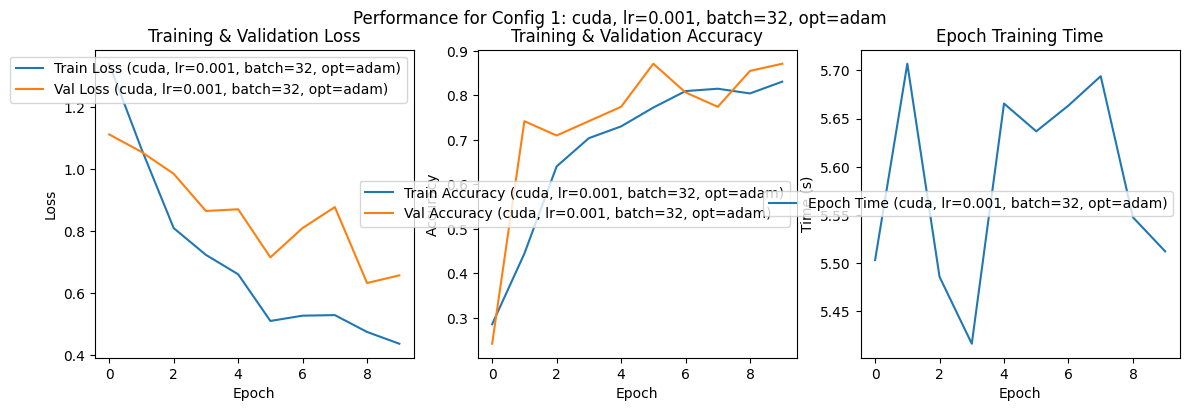

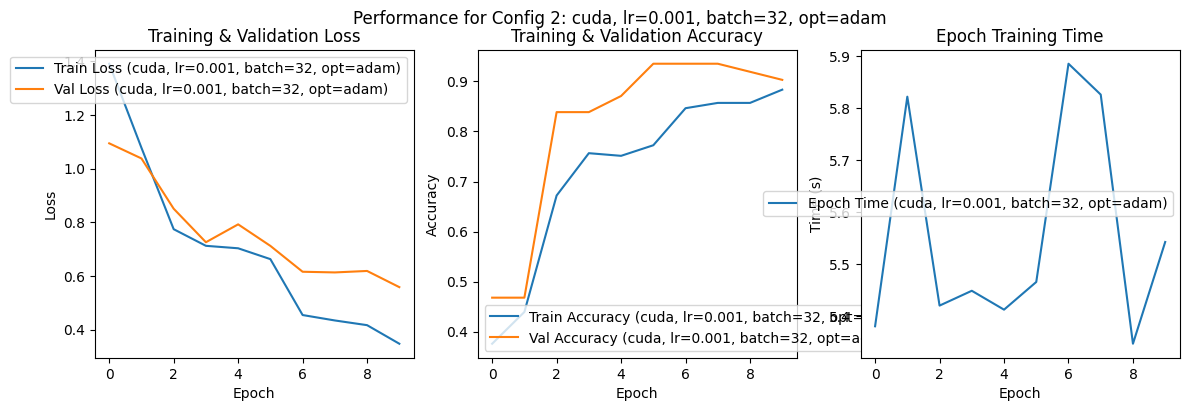

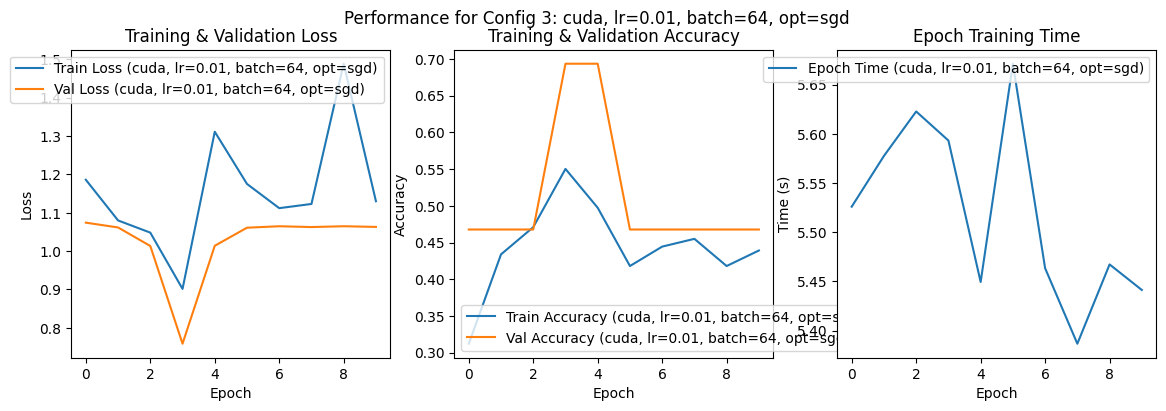

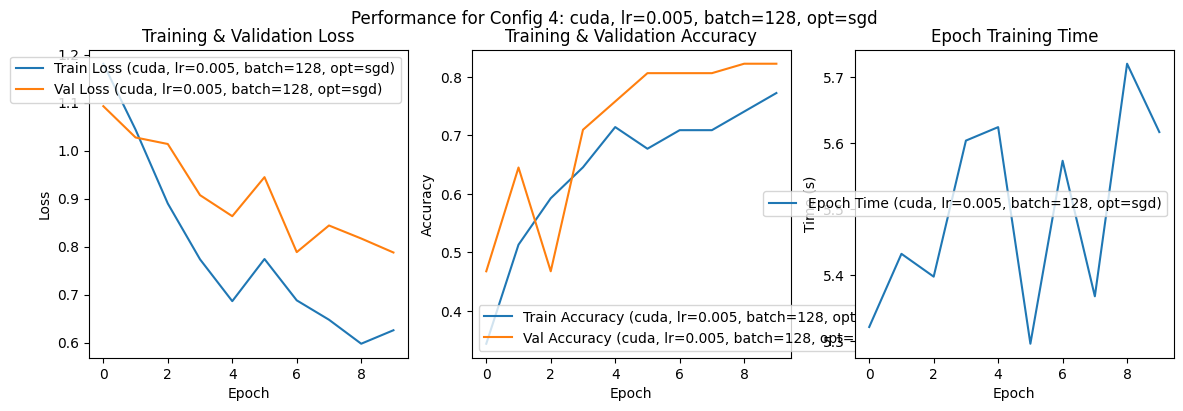

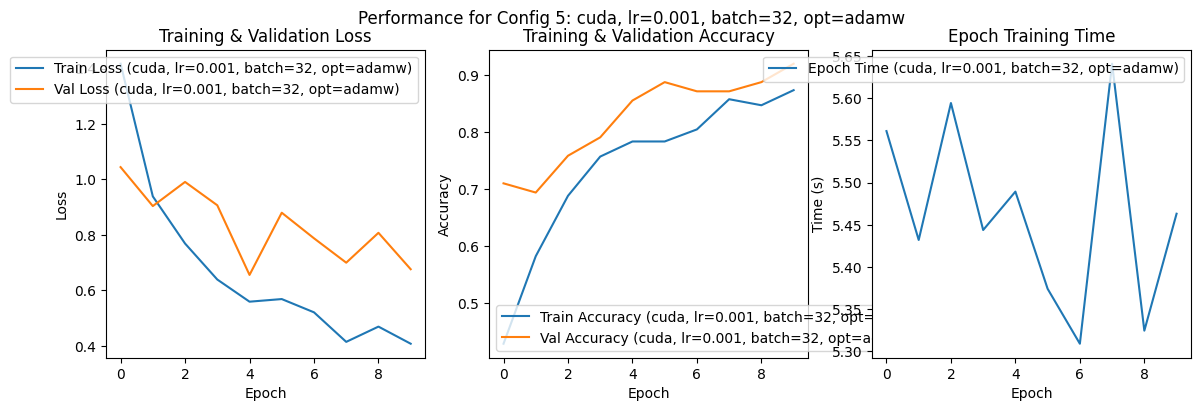

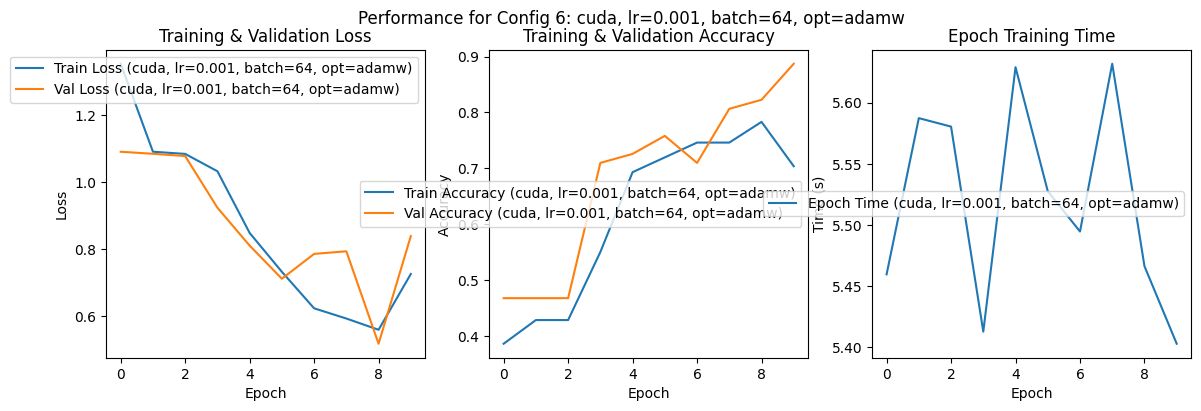

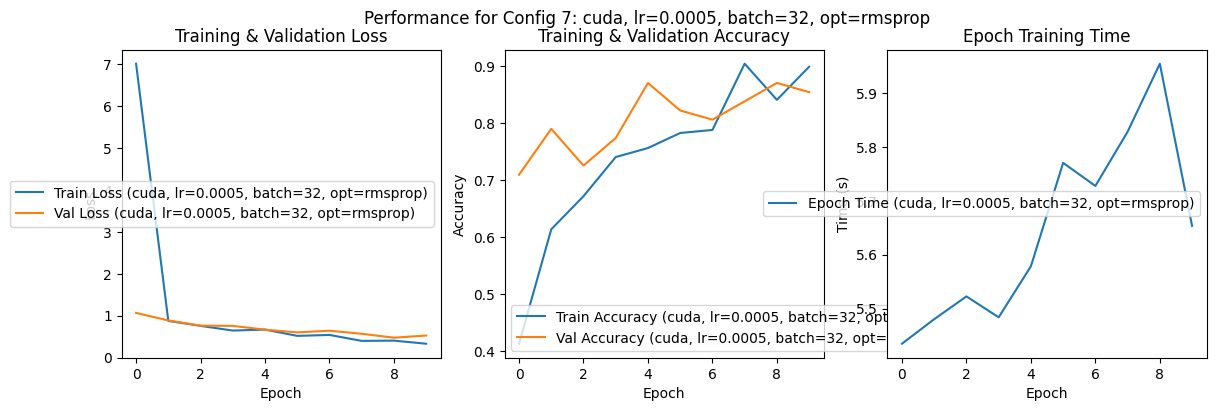

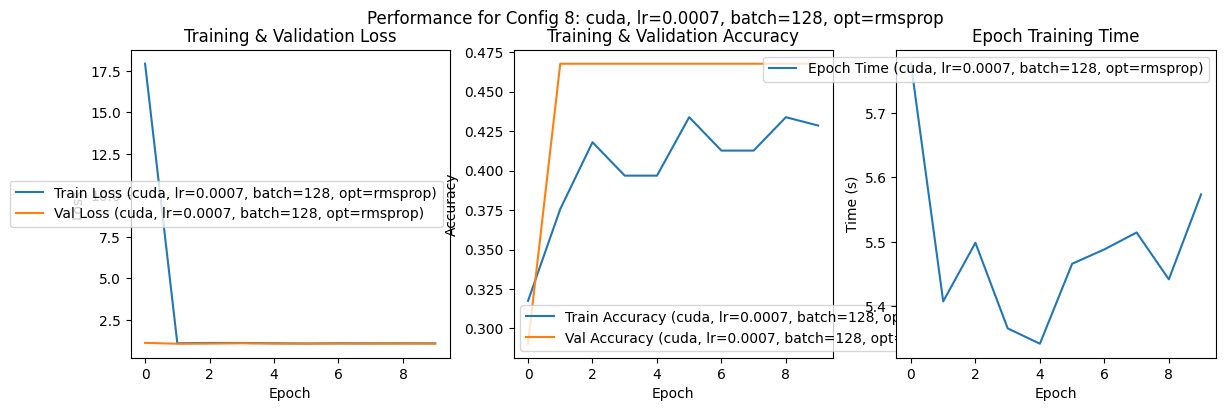

In [81]:
results
for i, result in enumerate(results):
    config = result['config']
    label = f"{config['device']}, lr={config['learning_rate']}, batch={config['batch_size']}, opt={config['optimizer']}"

    # Plot losses
    plt.figure(figsize=(14, 4))

    plt.subplot(1, 3, 1)
    plt.plot(result['train_losses'], label=f"Train Loss ({label})")
    plt.plot(result['val_losses'], label=f"Val Loss ({label})")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training & Validation Loss')

    # Plot accuracies
    plt.subplot(1, 3, 2)
    plt.plot(result['train_accuracies'], label=f"Train Accuracy ({label})")
    plt.plot(result['val_accuracies'], label=f"Val Accuracy ({label})")
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training & Validation Accuracy')

    # Plot epoch times
    plt.subplot(1, 3, 3)
    plt.plot(result['epoch_times'], label=f"Epoch Time ({label})")
    plt.xlabel('Epoch')
    plt.ylabel('Time (s)')
    plt.legend()
    plt.title('Epoch Training Time')

    plt.suptitle(f"Performance for Config {i+1}: {label}")
    plt.show()

In [79]:
results

[{'config': {'device': 'cuda',
   'learning_rate': 0.001,
   'batch_size': 32,
   'optimizer': 'adam',
   'weight_decay': 0},
  'train_losses': [1.339023230567811,
   1.0648758190649528,
   0.8098039258094061,
   0.7235557932071585,
   0.6611032094904985,
   0.5107682883424103,
   0.5278334357435741,
   0.5296390802456589,
   0.47533770591493635,
   0.43749473839209824],
  'train_accuracies': [0.2857142857142857,
   0.4444444444444444,
   0.6402116402116402,
   0.7037037037037037,
   0.7301587301587301,
   0.7724867724867724,
   0.8095238095238095,
   0.8148148148148148,
   0.8042328042328042,
   0.8306878306878307],
  'val_losses': [1.111379781076985,
   1.05531560221026,
   0.9847432278817699,
   0.8648982836354163,
   0.8704160509570953,
   0.715536069485449,
   0.8100875116163685,
   0.8774668151332486,
   0.6329765492869962,
   0.6575931637517868],
  'val_accuracies': [0.24193548387096775,
   0.7419354838709677,
   0.7096774193548387,
   0.7419354838709677,
   0.7741935483870968,
